# Exploratory Data Analysis ERA5 Dataset
This script is doing some EDA plotting.

### Imports

In [45]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cfeature
from matplotlib.colors import Normalize

### Load Preprocessed Dataset

In [46]:
ds_era5 = xr.open_dataset("data/era5_climate_data/era5-land-yearly-means-sliced.nc")

### Convert Kelvin to Celsius
Temporarily convert the temperature related variables from Kelvin to Celsius for easier readability in the plots

In [47]:
def to_celsius(ds, explicit_vars=('t2m', 'stl1', 'stl4')):
    """
    Convert Kelvin → Celsius for temperature variables

    Rules:
      1) Any var whose name starts with any of `explicit_vars` gets converted.
      2) Any var with attrs['units'] in {'K','kelvin','Kelvin'} gets converted.
      3) Skip variables already in °C (units contain 'c'/'°C' or attr flag set).
    """
    ds = ds.copy()

    def _is_temp_var(name, da):
        # Name-based rule
        if any(name.startswith(v) for v in explicit_vars):
            return True
        # Units-based rule
        u = str(da.attrs.get('units', '')).lower()
        if u in {'k', 'kelvin'}:
            return True
        return False

    for name, da in ds.data_vars.items():
        if not _is_temp_var(name, da):
            continue
        # Check unit
        u = str(da.attrs.get('units', '')).lower()
        if ('c' in u) or da.attrs.get('_units_converted_to') == 'C':
            continue

        # Convert Kelvin to Celsius
        ds[name] = da - 273.15

        new = ds[name]
        new.attrs['units'] = '°C'
        ln = new.attrs.get('long_name', '') or name
        if 'kelvin' in ln.lower() or '(k' in ln.lower():
            ln = ln.replace('Kelvin', 'Celsius').replace('kelvin', 'Celsius')
        new.attrs['long_name'] = ln if 'Celsius' in ln else f'{ln} (Celsius)'
        # mark to prevent re-conversion
        new.attrs['_units_converted_to'] = 'C'

    return ds

ds_era5_c = to_celsius(ds_era5)

### EDA

##### Seasonal and yearly differences across latitude and time
These plots show the seasonal differences in mean temperature and total precipitation over latitude and time for different seasons or yearly.

We can see that mean temperature varies a lot across the latitude (so South-North) which is expected and is also vastly different between winter and summer. The total precipitation is also different across the latitude but not as much and also varies across time.

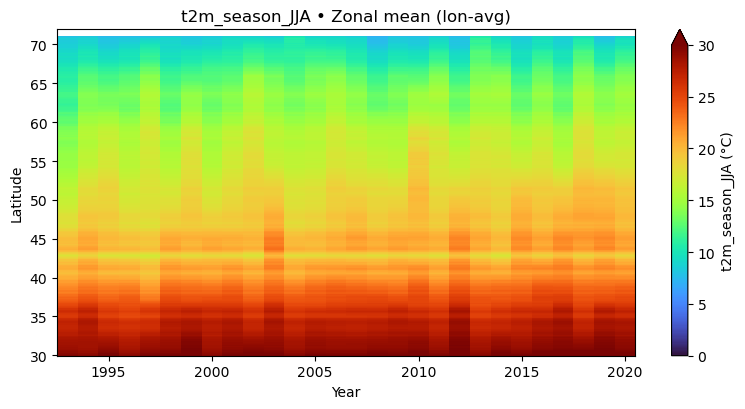

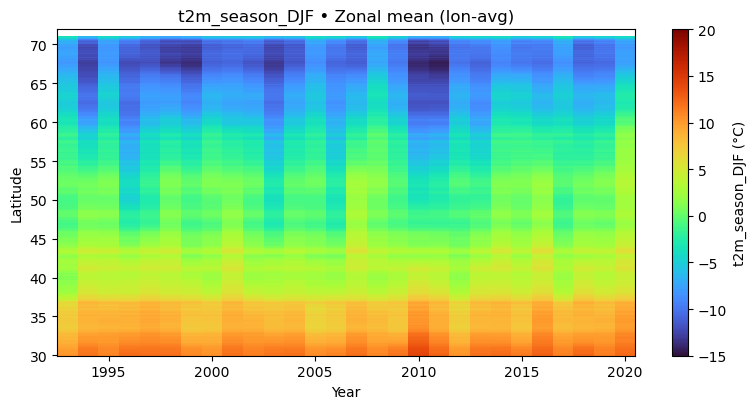

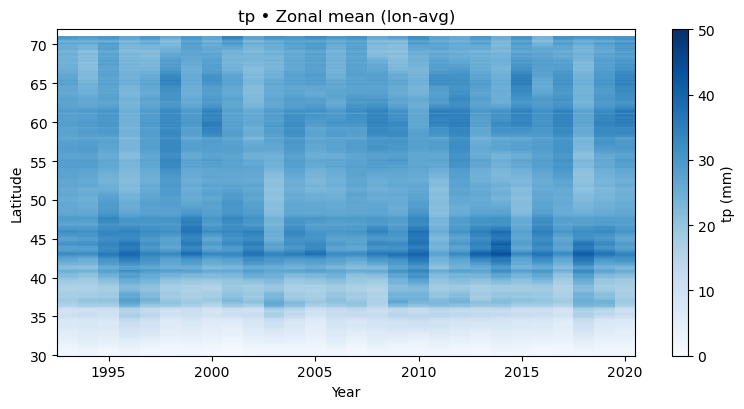

In [48]:
def plot_lat_year(clim, var, season=None, cmap='viridis', as_mm=False, vmin=None, vmax=None):
    """
    Zonal (longitude-mean) Hovmöller: latitude vs year.
    If 'season' is given (e.g., 'JJA'), expects f'{var}_season_{season}'.
    """
    if season is not None:
        varname = f'{var}_season_{season}'
    else:
        varname = var

    da = clim[varname]
    if as_mm:
        da = da * 1000.0

    zonal = da.mean('longitude', skipna=True)

    fig = plt.figure(figsize=(8, 4.2))
    zonal.T.plot(x='year', y='latitude', cmap=cmap, vmin=vmin, vmax=vmax,
                      cbar_kwargs={'label': f"{varname} ({'mm' if as_mm else da.attrs.get('units','')})".strip()})
    plt.title(f"{varname} • Zonal mean (lon-avg)")
    plt.xlabel('Year'); plt.ylabel('Latitude')
    plt.tight_layout()
    return fig

# Create the plots
figure_1 = plot_lat_year(ds_era5_c, 't2m', season='JJA', cmap='turbo', vmin=0, vmax=30)
figure_2 = plot_lat_year(ds_era5_c, 't2m', season='DJF', cmap='turbo', vmin=-15, vmax=20)
figure_3 = plot_lat_year(ds_era5_c, 'tp',  season=None,   cmap='Blues', as_mm=True, vmin=0, vmax=50)

# Save the figures as png images
figure_1.savefig("figures/temperature_JJA_time_latitude.png", dpi=300, bbox_inches='tight')
figure_2.savefig("figures/temperature_DJF_time_latitude.png", dpi=300, bbox_inches='tight')
figure_3.savefig("figures/precipitation_time_latitude.png", dpi=300, bbox_inches='tight')

##### Difference of variables across time
Use area weighting like in pft_data_preprocessing.ipynb to calculate the area weighted mean change of variables over time.

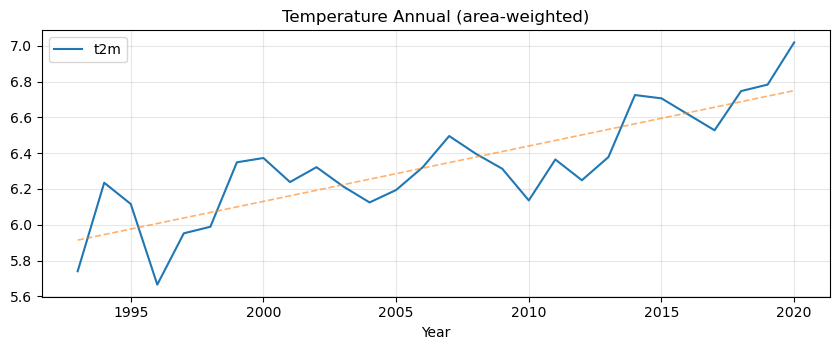

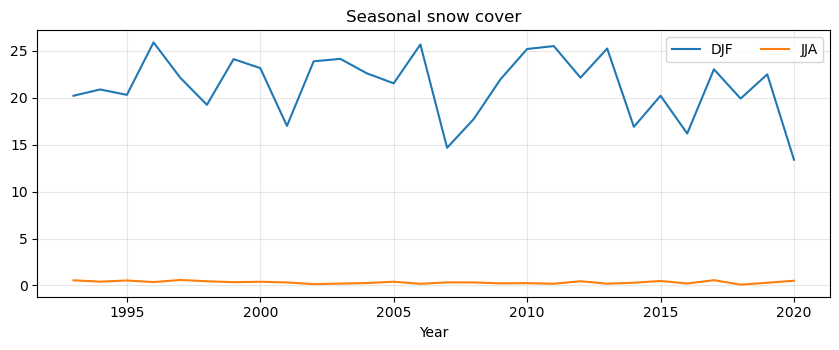

In [49]:
def earth_radius(lat):
    '''
    Calculate the radius of Earth based on latitude assuming oblate spheroid defined by WGS84
    '''
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)

    lat_rad = np.deg2rad(lat)
    lat_gc = np.arctan((1 - e2) * np.tan(lat_rad))

    radius = (a * (1 - e2)**0.5) / (1 - (e2 * np.cos(lat_gc)**2))**0.5
    
    return radius

def area_weights(lat_deg: xr.DataArray, lon_deg: xr.DataArray):
    """
    Return 1D array of cell areas (m^2 per cell, *per longitude*) for each latitude row
    on a regular lat/lon grid with uniform spacing.

    lat_deg, lon_deg: 1D arrays of grid *centers* in degrees (uniform spacing assumed)
    """

    R = earth_radius(lat_deg)

    dlat_deg = abs(np.diff(lat_deg).mean())
    dlon_deg = abs(np.diff(lon_deg).mean())
    
    lat_rad    = np.deg2rad(lat_deg)
    dlat_rad   = np.deg2rad(dlat_deg)
    dlon_rad   = np.deg2rad(dlon_deg)

    lat_up   = np.clip(lat_rad + dlat_rad/2, -np.pi/2,  np.pi/2)
    lat_down = np.clip(lat_rad - dlat_rad/2, -np.pi/2,  np.pi/2)

    w_lat = np.square(R) * (np.sin(lat_up) - np.sin(lat_down)) * dlon_rad 

    w_lat_values = w_lat.values if isinstance(w_lat, xr.DataArray) else w_lat
    lat_values = lat_deg.values if isinstance(lat_deg, xr.DataArray) else lat_deg
    
    area_weights = xr.DataArray(
        w_lat_values,
        dims=["latitude"],
        coords={"latitude": lat_values},
        attrs={
            "long_name": "area_weight_per_cell",
            "description": "Area weight per grid cell (m^2 per longitude cell)",
            "units": "m^2",
        }
    )

    return area_weights

def area_mean_series(clim, var):
    """
    Return area-weighted regional mean per year.
    """
    weights_lat = area_weights(clim['latitude'], clim['longitude'])
    weights_2d = weights_lat.broadcast_like(clim[var].isel(year=0, drop=True))
    num = (clim[var] * weights_2d).sum(dim=('latitude','longitude'), skipna=True)
    den = weights_2d.sum(dim=('latitude','longitude'))
    return num / den  # dims: year

def plot_regional_timeseries(clim, vars_or_pairs, title='Regional mean time series', add_trend=False):
    """
    Plot one or multiple regional time series. vars_or_pairs can be:
      - list of strings (variable names), or
      - list of (var, label) tuples to customize legend labels.
    If add_trend=True, adds a linear trend line for each series.
    """
    fig = plt.figure(figsize=(8.5, 3.6))
    if isinstance(vars_or_pairs[0], (list, tuple)):
        items = vars_or_pairs
    else:
        items = [(v, v) for v in vars_or_pairs]

    for var, label in items:
        series = area_mean_series(clim, var)
        y = series.values
        years = series['year'].values
        
        plt.plot(years, y, lw=1.5, label=label)
        
        if add_trend:
            z = np.polyfit(years, y, 1)
            p = np.poly1d(z)
            plt.plot(years, p(years), '--', alpha=0.6, lw=1.2)

    plt.xlabel('Year'); plt.grid(True, alpha=0.3)
    plt.legend(ncol=2)
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return fig

# Create the plots
figure_4 = plot_regional_timeseries(ds_era5_c, ['t2m'], title='Temperature Annual (area-weighted)', add_trend=True)
figure_5 = plot_regional_timeseries(ds_era5_c, [('snowc_season_DJF','DJF'), ('snowc_season_JJA','JJA')], title='Seasonal snow cover')

# Save the figures as png images
figure_4.savefig("figures/average_temperature_timeseries.png", dpi=300, bbox_inches='tight')
figure_5.savefig("figures/seasonal_snow_cover_timeseries.png", dpi=300, bbox_inches='tight')

##### Map plot utilities
Utility functions to decorate a map plot with borders, geoaxes etc.

In [50]:
def _region_extent(ds, margin=0.5):
    lat = ds['latitude'].values
    lon = ds['longitude'].values
    return [float(lon.min())-margin, float(lon.max())+margin,
            float(lat.min())-margin, float(lat.max())+margin]

def _geoaxes():
    projection = ccrs.PlateCarree()
    fig = plt.figure(figsize=(7.5, 6))
    ax = plt.axes(projection=projection)
    return fig, ax

def _decorate_map(ax, extent, coast_res='50m', add_land=True, add_borders=True, grid=True):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    if add_land:
        ax.add_feature(cfeature.LAND, facecolor='whitesmoke', zorder=0)
        ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=0)
    ax.coastlines(resolution=coast_res, linewidth=0.8)
    if add_borders:
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    if grid:
        gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, linewidth=0.4)
        gl.right_labels = False
        gl.top_labels = False

##### Seasonal Differences on a Map
These plots show the differences of a variable in different seasons in a map to show regional differences averaged over time.

We can see that there are huge differences for how much warmer it is in the summer compared to the winter. The biggest differences can be seen in the east in russia. For precipitation we can see differences for how much more total precipitation there is in the winter compared to the summer.

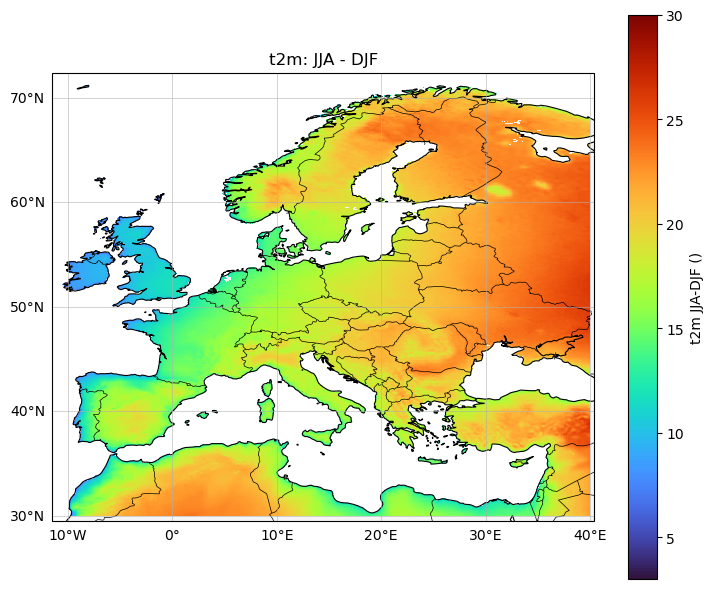

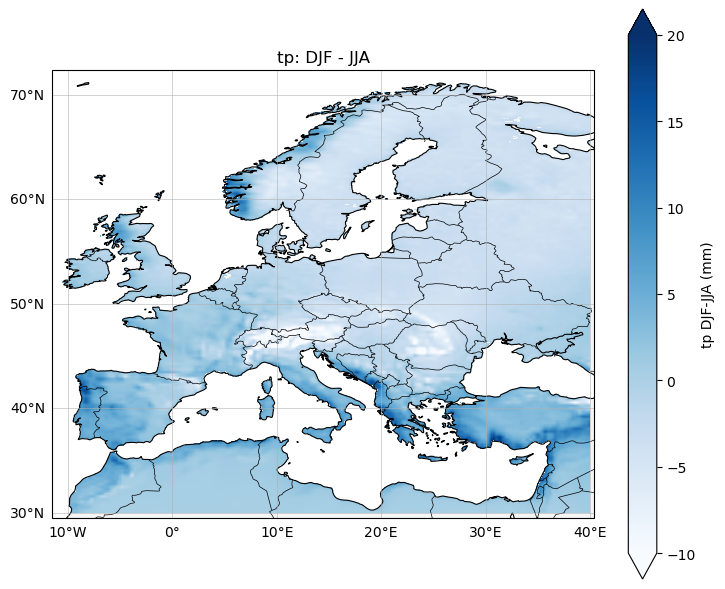

In [51]:
def plot_season_contrast(clim, var_base, season_pos='JJA', season_neg='DJF', cmap='coolwarm', vmin=None, vmax=None, as_mm=False):
    
    a = clim[f'{var_base}_season_{season_pos}'].mean('year', skipna=True)
    b = clim[f'{var_base}_season_{season_neg}'].mean('year', skipna=True)
    diff = a - b
    
    if as_mm:
        diff = diff * 1000.0

    fig, ax = _geoaxes()
    _decorate_map(ax, _region_extent(clim))
    diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
                   vmin=vmin, vmax=vmax,
                   cbar_kwargs={'label': f"{var_base} {season_pos}-{season_neg} ({'mm' if as_mm else ''})".strip()})
    ax.set_title(f"{var_base}: {season_pos} - {season_neg}")
    plt.tight_layout()
    return fig

figure_6 = plot_season_contrast(ds_era5_c, 't2m', season_pos='JJA', season_neg='DJF', cmap='turbo', vmin=3, vmax=30)
figure_7 = plot_season_contrast(ds_era5_c, 'tp',  season_pos='DJF', season_neg='JJA', cmap='Blues', as_mm=True, vmin=-10, vmax=20)

figure_6.savefig("figures/tempereature_season_contrast_JJA_DJF.png", dpi=300, bbox_inches='tight')
figure_7.savefig("figures/precipitation_season_contrast_JJA_DJF.png", dpi=300, bbox_inches='tight')

##### Average over years
These plots show the average over time of a single variable on a map.

The VPD says how dry the air is (higher = dryer).

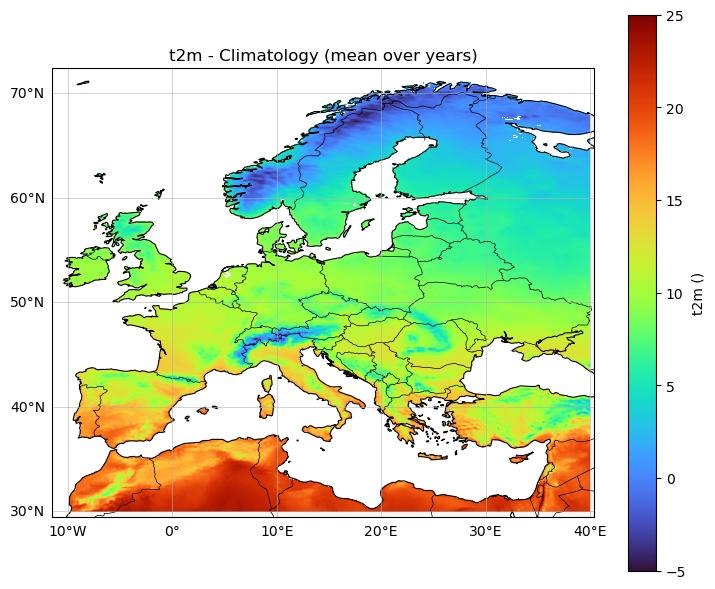

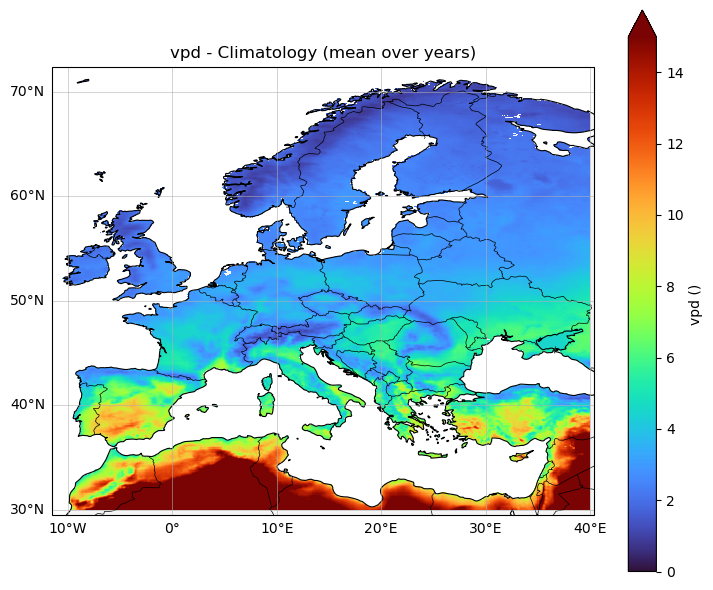

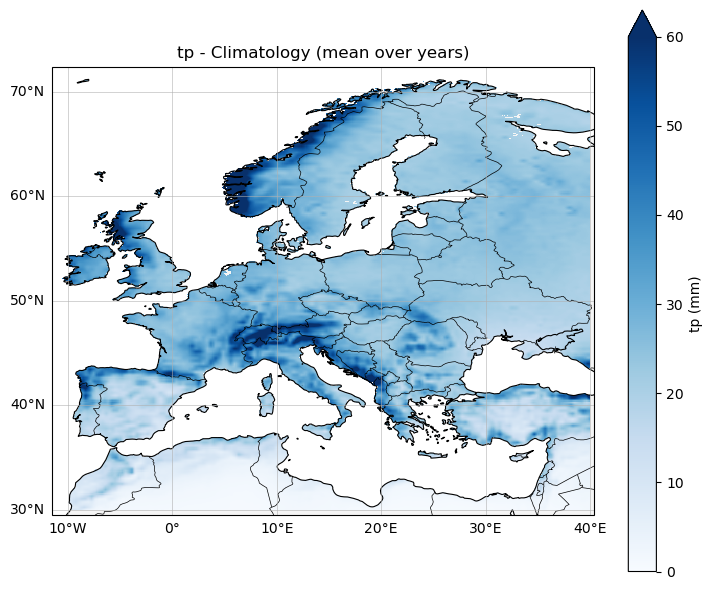

In [52]:
def plot_climatology_map(clim, var, vmin=None, vmax=None, cmap='viridis', as_mm=False):
    da = clim[var]
    mean_da = da.mean('year', skipna=True)
    if as_mm:
        mean_da = mean_da * 1000.0  # m -> mm
    label = f"{var} ({'mm' if as_mm else mean_da.attrs.get('units','')})".strip()

    fig, ax = _geoaxes()
    _decorate_map(ax, _region_extent(clim))

    mean_da.plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
        vmin=vmin, vmax=vmax,
        cbar_kwargs={'label': label}
    )
    ax.set_title(f"{var} - Climatology (mean over years)")
    plt.tight_layout()
    plt.show()
    return fig

# Create the plots
figure_8 = plot_climatology_map(ds_era5_c, 't2m', vmin=-5, vmax=25, cmap='turbo')
figure_9 = plot_climatology_map(ds_era5_c, 'vpd', vmin=0, vmax=15, cmap='turbo')
figure_10 = plot_climatology_map(ds_era5_c, 'tp',  vmin=0, vmax=60, cmap='Blues', as_mm=True)

# Save the figures as png images
figure_8.savefig("figures/temperature_climatology_map.png", dpi=300, bbox_inches='tight')
figure_9.savefig("figures/vpd_climatology_map.png", dpi=300, bbox_inches='tight')
figure_10.savefig("figures/precipitation_climatology_map.png", dpi=300, bbox_inches='tight')